In [48]:
pwd

'/Users/peterchatain/Documents/Classes/CS329P/project/riiid-test-answer-prediction'

In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from torch import nn
import sys
%cd /Users/peterchatain/Documents/Classes/CS329P/project/riiid-test-answer-prediction
%ls

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/Users/peterchatain/Documents/Classes/CS329P/project/riiid-test-answer-prediction
cv1_train.pickle                     cv1_valid.pickle.zip
cv1_train.pickle.zip                 cv1_valid_100k.pickle
cv1_train_1000k.pickle               example_sample_submission.csv
cv1_train_1000k_preprocessed.pickle  example_test.csv
cv1_train_100k.pickle                lectures.csv
cv1_train_100k_preprocessed.pickle   questions.csv
cv1_val_100k_preprocessed.pickle     riiid-test-answer-prediction.zip
cv1_val_10k.pickle                   riiideducation/
cv1_val_10k_preprocessed.pickle      train.csv
cv1_valid.pickle
cpu


In [49]:
train_path = "cv1_train_100k.pickle"
valid_path = "cv1_valid_100k.pickle"
question_path = "questions.csv"
lecture_path = "lectures.csv"
train = pd.read_pickle(train_path)
valid = pd.read_pickle(valid_path)
questions =  pd.read_csv(question_path)
lectures =  pd.read_csv(lecture_path)

def clean_df(train, is_valid = False, train_mean = 0, train_std = 0):

  train = train.sort_values(['user_id', 'timestamp'])
  train = train.reset_index(drop=True)
  train = train.drop(np.where(train['content_type_id'] == 1)[0], axis=0)
  train = train.reset_index(drop=True)
  train['part'] = np.array(questions['part'])[np.array(train['content_id'])]
  train = pd.concat([train, pd.get_dummies(train.part, prefix='part')], axis = 1)
  train = train.drop(["row_id", "content_id", "content_type_id", "task_container_id", "user_answer", "max_time_stamp", "rand_time_stamp", "viretual_time_stamp", "part"], axis=1)
  train.drop_duplicates(['user_id','timestamp' ], inplace = True)
  normalize_cols = ["prior_question_elapsed_time"]
  if not is_valid:
    train_mean = train[normalize_cols].mean()
    train_std = train[normalize_cols].std()
  train[normalize_cols] = (train[normalize_cols] - train_mean) / train_std
  train = train.fillna(0)
  return train, train_mean, train_std
train, train_mean, train_std = clean_df(train)
valid ,_, _ = clean_df(valid, is_valid = True, train_mean = train_mean, train_std = train_std)


In [50]:
user_id_train = set(np.unique(train["user_id"]))
user_id_valid = set(np.unique(valid["user_id"]))
intersection = user_id_train.intersection(user_id_valid)
print("there are {} unique users in train and {} unique users in valid, there are {} duplicate users : {}".format(len(user_id_train), len(user_id_valid), len(intersection), intersection))

for duplicate_user in intersection:
  valid = valid[valid["user_id"]!=duplicate_user]

train = train.reset_index(drop=True)

valid = valid.reset_index(drop=True)



there are 2210 unique users in train and 2824 unique users in valid, there are 2 duplicate users : {124443281, 1209880307}


In [51]:
mapmap_train = np.unique(train["user_id"], return_counts = True)[1]
mapmap_valid = np.unique(valid["user_id"], return_counts = True)[1]

mu = np.mean(train['answered_correctly'])
sigma = np.std(train['answered_correctly'])
train['prior_answered_correctly'] = (train['answered_correctly'] - mu) / sigma

temp = np.append(0, train['prior_answered_correctly'][0:-1])
temp[np.cumsum(mapmap_train)[:-1]] = 0
train['prior_answered_correctly']= temp

print(f"mu = {mu}, sigma = {sigma}")


mu = np.mean(valid['answered_correctly'])
sigma = np.std(valid['answered_correctly'])
valid['prior_answered_correctly'] = (valid['answered_correctly'] - mu) / sigma

print(f"mu = {mu}, sigma = {sigma}")

temp = np.append(0, valid['prior_answered_correctly'][0:-1])
temp[np.cumsum(mapmap_valid)[:-1]] = 0
valid['prior_answered_correctly']= temp


valid['prior_answered_correctly'] = (valid['prior_answered_correctly']>0) + 0
train['prior_answered_correctly'] = (train['prior_answered_correctly']>0) + 0



mu = 0.5826356667339117, sigma = 0.49312406814456117
mu = 0.6522629586213401, sigma = 0.47625202512102355


In [52]:
train

,timestamp,user_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part_1,part_2,part_3,part_4,part_5,part_6,part_7,prior_answered_correctly
0,0,44331,0,0.000000,False,0,0,0,0,1,0,0,0
1,35028,44331,0,1.339109,False,0,0,0,0,1,0,0,0
2,61706,44331,1,0.571721,False,0,0,0,0,1,0,0,0
3,85685,44331,0,0.060129,False,0,1,0,0,0,0,0,1
4,141228,44331,1,-0.131718,False,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79307,223228,2144322103,1,0.124078,False,0,0,0,0,1,0,0,1
79308,246293,2144322103,1,-0.131718,False,0,1,0,0,0,0,0,1
79309,370646,2144322103,1,-0.387514,False,0,1,0,0,0,0,0,1
79310,403714,2144322103,1,-0.451463,True,0,1,0,0,0,0,0,1


In [53]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74217 entries, 0 to 74216
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   timestamp                       74217 non-null  int64  
 1   user_id                         74217 non-null  int32  
 2   answered_correctly              74217 non-null  int8   
 3   prior_question_elapsed_time     74217 non-null  float32
 4   prior_question_had_explanation  74217 non-null  boolean
 5   part_1                          74217 non-null  uint8  
 6   part_2                          74217 non-null  uint8  
 7   part_3                          74217 non-null  uint8  
 8   part_4                          74217 non-null  uint8  
 9   part_5                          74217 non-null  uint8  
 10  part_6                          74217 non-null  uint8  
 11  part_7                          74217 non-null  uint8  
 12  prior_answered_correctly        

In [10]:
print("train", train.shape)
print("valid", valid.shape)


train (79312, 13)
valid (7456, 13)


In [ ]:
# mapmap_train = np.unique(train["user_id"], return_counts = True)[1]
# mapmap_valid = np.unique(valid["user_id"], return_counts = True)[1]
# plt.plot(mapmap_train)
# plt.plot(mapmap_valid

In [ ]:
# create a histogram of the 

In [54]:
from tqdm import tqdm

WINDOW_LENGTH = 256
FEATURE_DIM = train.shape[1]

def add_window_padding(train):
    train_padded = list()
    loss_mask = list()
    mapmap = np.unique(train['user_id'], return_counts=True)[1]
    lower = np.cumsum(mapmap)
    start = 0
    for l, m in tqdm(zip(lower, mapmap)):
        someee = (((l-start-1)//WINDOW_LENGTH)+1)*WINDOW_LENGTH
        end_index = start + someee
        padded = end_index - l
        temp = np.zeros((1, someee, FEATURE_DIM))
        mask = np.zeros((1, someee))
        temp[:,:l-start] = np.array(train.iloc[start:l], dtype = np.float)
        mask[:, :l-start] =1
        temp = np.reshape(temp, (-1,WINDOW_LENGTH,FEATURE_DIM))
        mask = np.reshape(mask, (-1, WINDOW_LENGTH))
        #Append
        train_padded.append(temp)
        loss_mask.append(mask)
        #Update start
        start = l
    train_padded = np.vstack(train_padded)
    train_padded = torch.from_numpy(train_padded).to(device)
    loss_mask = np.vstack(loss_mask)
    loss_mask = torch.from_numpy(loss_mask).to(device)
    return train_padded, mapmap, loss_mask

train_padded, mapmap_train, loss_mask_train = add_window_padding(train)
valid_padded, mapmap_valid, loss_mask_valid= add_window_padding(valid)

0it [00:00, ?it/s]/var/folders/l_/9kp_4l1d14g94h3qntsw3w7m0000gn/T/ipykernel_47189/1854552066.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp[:,:l-start] = np.array(train.iloc[start:l], dtype = np.float)
2210it [00:00, 2646.43it/s]
2822it [00:00, 3175.27it/s]


In [55]:
t_train_y =train_padded[:,:,2:3] > 0 
t_train_x = train_padded[:,:,3:]
print(t_train_y.shape)
print(t_train_x.shape)
print(loss_mask_train.shape)

t_valid_y =valid_padded[:,:,2:3] > 0
t_valid_x = valid_padded[:,:,3:]
print(t_valid_y.shape)
print(t_valid_x.shape)
print(loss_mask_valid.shape)

torch.Size([2235, 256, 1])
torch.Size([2235, 256, 10])
torch.Size([2235, 256])
torch.Size([2836, 256, 1])
torch.Size([2836, 256, 10])
torch.Size([2836, 256])


In [56]:
batch_size = 16

def batchify(t_train_x, t_train_y, loss_mask_train, batch_size):
  
  total = (t_train_y.shape[0]//batch_size-1)*batch_size
  t_train_y = t_train_y[:total]
  t_train_x = t_train_x[:total, :, :] 
  loss_mask_train = loss_mask_train[:total,:]
  num_batches = int(t_train_y.shape[0] / batch_size)
  t_train_x = t_train_x.reshape(num_batches, batch_size, WINDOW_LENGTH, 10)
  t_train_y = t_train_y.reshape(num_batches,batch_size, -1)
  loss_mask_train = loss_mask_train.reshape(num_batches, batch_size, -1)
  print(t_train_x.shape)
  print(t_train_y.shape)
  print(loss_mask_train.shape)
  return t_train_x, t_train_y, loss_mask_train
t_train_x, t_train_y , loss_mask_train=  batchify(t_train_x, t_train_y, loss_mask_train, batch_size)
t_valid_x, t_valid_y , loss_mask_valid=  batchify(t_valid_x, t_valid_y, loss_mask_valid,batch_size)

torch.Size([138, 16, 256, 10])
torch.Size([138, 16, 256])
torch.Size([138, 16, 256])
torch.Size([176, 16, 256, 10])
torch.Size([176, 16, 256])
torch.Size([176, 16, 256])


In [57]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int = 9, dropout: float = 0.1, max_len: int = 512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x.permute(1, 0, 2) + self.pe[:x.size(1)]
        x = x.permute(1, 0, 2)
        return self.dropout(x)


In [58]:
class TransformerModel(torch.nn.Module):
    def __init__(self, n_encoder_layers=3, d_model=9, n_heads=3, dropout = 0.1):
        super(TransformerModel, self).__init__()
        self.n_encoder_layers = n_encoder_layers
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model)
        self.tranformer_encoder = TransformerModelEncoder(n_encoder_layers, d_model, n_heads,dropout)
        self.decoder = torch.nn.Linear(d_model, 1)
    def forward(self, X):
        X = self.positional_encoding(X)
        out = self.tranformer_encoder(X)
        out = self.decoder(out)
        return out

In [59]:
class TransformerModelEncoder(torch.nn.Module):
    def __init__(self, n_encoder_layers=3, d_model=9, n_heads=3, dropout= 0.1):
        super(TransformerModelEncoder, self).__init__()
        self.encoder = []
        self.n_encoder_layers = n_encoder_layers
        for i in range(n_encoder_layers):
            self.encoder.append(TransformerEncoderLayer(n_heads,d_model, dropout))
    def forward(self, X):
        for i in range(self.n_encoder_layers):
            X = self.encoder[i](X)
        return X

In [60]:
class TransformerEncoderLayer(torch.nn.Module):
    def __init__(self, n_heads=3,d_model=9, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiheadAttention(n_heads,d_model, dropout)
        self.linear = torch.nn.Linear(d_model, d_model)
        self.linear2 = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm = torch.nn.LayerNorm([WINDOW_LENGTH, d_model])
    def forward(self, X):
        oldX = X
        X = self.attention(X)
        X = self.linear(X) 
        X = self.layer_norm(self.dropout(X) + oldX)
        return X

In [62]:
class MultiheadAttention(torch.nn.Module):
    #Note that d_model should be divisible by the number of heads (n_heads)
    def __init__(self, n_heads=3, d_model=9, dropout=0.1):
        super(MultiheadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dropout = dropout
        self.small_d = d_model//n_heads
        
        self.Q = torch.nn.Linear(d_model, d_model)
        self.K = torch.nn.Linear(d_model, d_model)
        self.V = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm([WINDOW_LENGTH, d_model])
    #Note that X is input with the size (# of strings, Max Length of strings, #features of string)
    def forward(self, X):
        q_X = self.Q(X)
        k_X =  self.K(X)
        v_X =  self.V(X)
        max_len = X.shape[1]
        batch_size = X.shape[0]
        q_X_h = q_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0,2,1,3)
        k_X_h = k_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0,2,3,1)
        v_X_h = v_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0, 2, 1, 3)
        mask = torch.triu(torch.ones(max_len,max_len)*float('-inf'), diagonal=1)
        score = torch.softmax((q_X_h @ k_X_h)/np.sqrt(self.small_d) + mask, axis = -1)
                
        result = (score@v_X_h).permute(0, 2, 1, 3)
        result = result.reshape(batch_size, max_len, self.d_model)
        result = self.layer_norm(X + self.dropout(result))
        return result

In [66]:
Q = torch.randn((9, 15))
K = torch.randn((9, 15))
V = torch.randn((9, 15))
small_d = 5
n_heads = 3

X = t_train_x[0]

# Train LSTM

  8%|▊         | 4/50 [00:00<00:01, 31.30it/s]

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0



 24%|██▍       | 12/50 [00:00<00:01, 34.17it/s]

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])


 40%|████      | 20/50 [00:00<00:00, 33.84it/s]

avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0



 48%|████▊     | 24/50 [00:00<00:00, 30.63it/s]

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])


 62%|██████▏   | 31/50 [00:01<00:00, 28.30it/s]

avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0



 74%|███████▍  | 37/50 [00:01<00:00, 27.39it/s]

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])


 86%|████████▌ | 43/50 [00:01<00:00, 26.94it/s]

avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 1.0

torch.Size([16, 256])
avg is 0.997802734375

torch.Size([16, 256])
avg is 0.99560546875

torch.Size([16, 256])
avg is 0.99951171875



 92%|█████████▏| 46/50 [00:01<00:00, 26.81it/s]

torch.Size([16, 256])
avg is 0.99853515625

torch.Size([16, 256])
avg is 0.992919921875

torch.Size([16, 256])
avg is 0.99560546875

torch.Size([16, 256])
avg is 0.9921875

torch.Size([16, 256])
avg is 0.998291015625

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 28.93it/s]


avg is 0.98974609375

torch.Size([16, 256])
avg is 0.992431640625

train
evaluation acc: 0.5772834470010836, loss: 0.0012558019297057624
valid
evaluation acc: 0.649468646061491, loss: 0.0015145222619708


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 256])
avg is 0.99560546875



  8%|▊         | 4/50 [00:00<00:01, 31.48it/s]

torch.Size([16, 256])
avg is 0.991943359375

torch.Size([16, 256])
avg is 0.993408203125

torch.Size([16, 256])
avg is 0.989990234375

torch.Size([16, 256])
avg is 0.99658203125

torch.Size([16, 256])
avg is 0.990478515625

torch.Size([16, 256])
avg is 0.98388671875



 16%|█▌        | 8/50 [00:00<00:01, 33.40it/s]

torch.Size([16, 256])
avg is 0.982177734375



 24%|██▍       | 12/50 [00:00<00:01, 33.85it/s]

torch.Size([16, 256])
avg is 0.971435546875

torch.Size([16, 256])
avg is 0.958984375

torch.Size([16, 256])
avg is 0.946044921875

torch.Size([16, 256])
avg is 0.9677734375

torch.Size([16, 256])
avg is 0.970458984375

torch.Size([16, 256])
avg is 0.967041015625

torch.Size([16, 256])
avg is 0.98291015625



 40%|████      | 20/50 [00:00<00:00, 33.64it/s]

torch.Size([16, 256])
avg is 0.971923828125

torch.Size([16, 256])
avg is 0.958740234375

torch.Size([16, 256])
avg is 0.97021484375

torch.Size([16, 256])
avg is 0.97265625

torch.Size([16, 256])
avg is 0.9736328125

torch.Size([16, 256])
avg is 0.97265625

torch.Size([16, 256])
avg is 0.978515625



 56%|█████▌    | 28/50 [00:00<00:00, 34.53it/s]

torch.Size([16, 256])
avg is 0.96728515625

torch.Size([16, 256])
avg is 0.972412109375

torch.Size([16, 256])
avg is 0.9833984375

torch.Size([16, 256])
avg is 0.9814453125

torch.Size([16, 256])
avg is 0.97705078125

torch.Size([16, 256])
avg is 0.9755859375

torch.Size([16, 256])
avg is 0.979248046875

torch.Size([16, 256])


 64%|██████▍   | 32/50 [00:00<00:00, 34.77it/s]

avg is 0.975341796875

torch.Size([16, 256])
avg is 0.978515625

torch.Size([16, 256])
avg is 0.952880859375

torch.Size([16, 256])
avg is 0.8896484375

torch.Size([16, 256])
avg is 0.957763671875

torch.Size([16, 256])
avg is 0.9033203125

torch.Size([16, 256])
avg is 0.922607421875



 72%|███████▏  | 36/50 [00:01<00:00, 34.95it/s]

torch.Size([16, 256])
avg is 0.919677734375



 80%|████████  | 40/50 [00:01<00:00, 35.27it/s]

torch.Size([16, 256])
avg is 0.931640625

torch.Size([16, 256])
avg is 0.9248046875

torch.Size([16, 256])
avg is 0.8740234375

torch.Size([16, 256])
avg is 0.94091796875

torch.Size([16, 256])
avg is 0.82763671875

torch.Size([16, 256])
avg is 0.950439453125

torch.Size([16, 256])


 88%|████████▊ | 44/50 [00:01<00:00, 35.37it/s]

avg is 0.971923828125

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 34.68it/s]

avg is 0.91796875

torch.Size([16, 256])
avg is 0.899658203125

torch.Size([16, 256])
avg is 0.752197265625

torch.Size([16, 256])
avg is 0.931396484375

torch.Size([16, 256])
avg is 0.92041015625

torch.Size([16, 256])
avg is 0.9697265625

train


evaluation acc: 0.6053285741602397, loss: 0.0012344544329187391
valid
evaluation acc: 0.6557962196803764, loss: 0.0015001647403984422


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 256])


  8%|▊         | 4/50 [00:00<00:01, 34.31it/s]

avg is 0.975830078125

torch.Size([16, 256])
avg is 0.96630859375

torch.Size([16, 256])
avg is 0.96728515625

torch.Size([16, 256])
avg is 0.95263671875

torch.Size([16, 256])
avg is 0.8974609375

torch.Size([16, 256])
avg is 0.8935546875

torch.Size([16, 256])
avg is 0.938232421875

torch.Size([16, 256])
avg is 0.894287109375



 24%|██▍       | 12/50 [00:00<00:01, 35.24it/s]

torch.Size([16, 256])
avg is 0.9443359375

torch.Size([16, 256])
avg is 0.9306640625

torch.Size([16, 256])
avg is 0.90771484375

torch.Size([16, 256])
avg is 0.89404296875

torch.Size([16, 256])
avg is 0.9189453125

torch.Size([16, 256])
avg is 0.941162109375

torch.Size([16, 256])


 40%|████      | 20/50 [00:00<00:00, 31.91it/s]

avg is 0.890380859375

torch.Size([16, 256])
avg is 0.792236328125

torch.Size([16, 256])
avg is 0.8974609375

torch.Size([16, 256])
avg is 0.913330078125

torch.Size([16, 256])
avg is 0.949462890625

torch.Size([16, 256])
avg is 0.900634765625

torch.Size([16, 256])
avg is 0.71728515625



 56%|█████▌    | 28/50 [00:00<00:00, 34.47it/s]

torch.Size([16, 256])
avg is 0.956787109375

torch.Size([16, 256])
avg is 0.900634765625

torch.Size([16, 256])
avg is 0.723876953125

torch.Size([16, 256])
avg is 0.964111328125

torch.Size([16, 256])
avg is 0.9287109375

torch.Size([16, 256])
avg is 0.94140625

torch.Size([16, 256])
avg is 0.9619140625

torch.Size([16, 256])


 64%|██████▍   | 32/50 [00:00<00:00, 34.95it/s]

avg is 0.9501953125

torch.Size([16, 256])
avg is 0.957763671875

torch.Size([16, 256])
avg is 0.9443359375

torch.Size([16, 256])
avg is 0.85302734375

torch.Size([16, 256])
avg is 0.854736328125

torch.Size([16, 256])
avg is 0.943115234375

torch.Size([16, 256])
avg is 0.783203125

torch.Size([16, 256])


 80%|████████  | 40/50 [00:01<00:00, 31.61it/s]

avg is 0.89013671875

torch.Size([16, 256])
avg is 0.906982421875

torch.Size([16, 256])
avg is 0.929931640625

torch.Size([16, 256])
avg is 0.9248046875

torch.Size([16, 256])
avg is 0.878662109375

torch.Size([16, 256])
avg is 0.93408203125

torch.Size([16, 256])
avg is 0.79443359375



 96%|█████████▌| 48/50 [00:01<00:00, 34.04it/s]

torch.Size([16, 256])
avg is 0.94580078125

torch.Size([16, 256])
avg is 0.9638671875

torch.Size([16, 256])
avg is 0.898681640625

torch.Size([16, 256])
avg is 0.845703125

torch.Size([16, 256])
avg is 0.675537109375

torch.Size([16, 256])
avg is 0.84716796875

torch.Size([16, 256])
avg is 0.881103515625

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 33.72it/s]


avg is 0.94384765625

train
evaluation acc: 0.6155905411434763, loss: 0.0012233823188278208
valid
evaluation acc: 0.6485762959357508, loss: 0.0015014596092724564


  8%|▊         | 4/50 [00:00<00:01, 36.70it/s]

torch.Size([16, 256])
avg is 0.9375

torch.Size([16, 256])
avg is 0.92626953125

torch.Size([16, 256])
avg is 0.87158203125

torch.Size([16, 256])
avg is 0.943359375

torch.Size([16, 256])
avg is 0.9072265625

torch.Size([16, 256])
avg is 0.9287109375

torch.Size([16, 256])
avg is 0.9453125

torch.Size([16, 256])


 24%|██▍       | 12/50 [00:00<00:01, 37.13it/s]

avg is 0.917236328125

torch.Size([16, 256])
avg is 0.952392578125

torch.Size([16, 256])
avg is 0.939453125

torch.Size([16, 256])
avg is 0.92333984375

torch.Size([16, 256])
avg is 0.919189453125

torch.Size([16, 256])
avg is 0.927001953125

torch.Size([16, 256])
avg is 0.94580078125

torch.Size([16, 256])
avg is 0.904052734375

torch.Size([16, 256])


 40%|████      | 20/50 [00:00<00:00, 35.46it/s]

avg is 0.790283203125

torch.Size([16, 256])
avg is 0.899169921875

torch.Size([16, 256])
avg is 0.91162109375

torch.Size([16, 256])
avg is 0.941650390625

torch.Size([16, 256])
avg is 0.882568359375

torch.Size([16, 256])
avg is 0.698974609375

torch.Size([16, 256])
avg is 0.947021484375



 56%|█████▌    | 28/50 [00:00<00:00, 32.46it/s]

torch.Size([16, 256])
avg is 0.84228515625

torch.Size([16, 256])
avg is 0.643310546875

torch.Size([16, 256])
avg is 0.95361328125

torch.Size([16, 256])
avg is 0.92041015625

torch.Size([16, 256])
avg is 0.927490234375

torch.Size([16, 256])
avg is 0.954833984375

torch.Size([16, 256])


 72%|███████▏  | 36/50 [00:01<00:00, 34.36it/s]

avg is 0.93212890625

torch.Size([16, 256])
avg is 0.950439453125

torch.Size([16, 256])
avg is 0.9365234375

torch.Size([16, 256])
avg is 0.837890625

torch.Size([16, 256])
avg is 0.87255859375

torch.Size([16, 256])
avg is 0.94384765625

torch.Size([16, 256])
avg is 0.78515625

torch.Size([16, 256])
avg is 0.900634765625



 80%|████████  | 40/50 [00:01<00:00, 35.07it/s]

torch.Size([16, 256])
avg is 0.91650390625

torch.Size([16, 256])
avg is 0.941162109375

torch.Size([16, 256])
avg is 0.9443359375

torch.Size([16, 256])
avg is 0.920654296875

torch.Size([16, 256])
avg is 0.93408203125

torch.Size([16, 256])
avg is 0.821044921875

torch.Size([16, 256])
avg is 0.9541015625

torch.Size([16, 256])


 96%|█████████▌| 48/50 [00:01<00:00, 31.99it/s]

avg is 0.96630859375

torch.Size([16, 256])
avg is 0.905029296875

torch.Size([16, 256])
avg is 0.85009765625

torch.Size([16, 256])
avg is 0.671875

torch.Size([16, 256])
avg is 0.82470703125

torch.Size([16, 256])
avg is 0.876708984375

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 33.59it/s]


avg is 0.9443359375

train
evaluation acc: 0.6178851424564982, loss: 0.001220835051493333
valid
evaluation acc: 0.6500365052324166, loss: 0.0015017610744341347


  8%|▊         | 4/50 [00:00<00:01, 31.01it/s]

torch.Size([16, 256])
avg is 0.93408203125

torch.Size([16, 256])
avg is 0.9033203125

torch.Size([16, 256])
avg is 0.7392578125

torch.Size([16, 256])
avg is 0.929931640625

torch.Size([16, 256])
avg is 0.8515625

torch.Size([16, 256])
avg is 0.868408203125



 22%|██▏       | 11/50 [00:00<00:01, 28.20it/s]

torch.Size([16, 256])
avg is 0.9326171875

torch.Size([16, 256])
avg is 0.841064453125

torch.Size([16, 256])
avg is 0.947265625

torch.Size([16, 256])
avg is 0.935546875

torch.Size([16, 256])
avg is 0.911376953125

torch.Size([16, 256])
avg is 0.879638671875



 38%|███▊      | 19/50 [00:00<00:00, 32.47it/s]

torch.Size([16, 256])
avg is 0.9208984375

torch.Size([16, 256])
avg is 0.94384765625

torch.Size([16, 256])
avg is 0.82763671875

torch.Size([16, 256])
avg is 0.76220703125

torch.Size([16, 256])
avg is 0.884765625

torch.Size([16, 256])
avg is 0.902587890625

torch.Size([16, 256])
avg is 0.93505859375

torch.Size([16, 256])


 54%|█████▍    | 27/50 [00:00<00:00, 34.51it/s]

avg is 0.871826171875

torch.Size([16, 256])
avg is 0.6826171875

torch.Size([16, 256])
avg is 0.945068359375

torch.Size([16, 256])
avg is 0.774658203125

torch.Size([16, 256])
avg is 0.544677734375

torch.Size([16, 256])
avg is 0.942138671875

torch.Size([16, 256])
avg is 0.913818359375

torch.Size([16, 256])
avg is 0.919677734375



 62%|██████▏   | 31/50 [00:00<00:00, 35.08it/s]

torch.Size([16, 256])
avg is 0.953125

torch.Size([16, 256])
avg is 0.884765625

torch.Size([16, 256])
avg is 0.947265625

torch.Size([16, 256])
avg is 0.919677734375

torch.Size([16, 256])
avg is 0.819580078125

torch.Size([16, 256])
avg is 0.877197265625

torch.Size([16, 256])
avg is 0.938232421875

torch.Size([16, 256])


 78%|███████▊  | 39/50 [00:01<00:00, 35.78it/s]

avg is 0.752197265625

torch.Size([16, 256])
avg is 0.88427734375

torch.Size([16, 256])
avg is 0.907958984375

torch.Size([16, 256])
avg is 0.933349609375

torch.Size([16, 256])
avg is 0.940673828125

torch.Size([16, 256])
avg is 0.922119140625

torch.Size([16, 256])
avg is 0.933837890625

torch.Size([16, 256])
avg is 0.801513671875

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 34.46it/s]

avg is 0.95703125

torch.Size([16, 256])
avg is 0.966064453125

torch.Size([16, 256])
avg is 0.911376953125

torch.Size([16, 256])
avg is 0.877685546875

torch.Size([16, 256])
avg is 0.688232421875

torch.Size([16, 256])
avg is 0.84326171875

torch.Size([16, 256])
avg is 0.880859375

torch.Size([16, 256])
avg is 0.947021484375

train


evaluation acc: 0.6180763592325833, loss: 0.0012196644954871698
valid
evaluation acc: 0.6519834509613045, loss: 0.0015008617222782776


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 256])
avg is 0.94091796875

torch.Size([16, 256])
avg is 0.923583984375

torch.Size([16, 256])


  8%|▊         | 4/50 [00:00<00:01, 36.36it/s]

avg is 0.79931640625

torch.Size([16, 256])
avg is 0.93603515625

torch.Size([16, 256])
avg is 0.8984375

torch.Size([16, 256])
avg is 0.929443359375

torch.Size([16, 256])
avg is 0.940673828125



 16%|█▌        | 8/50 [00:00<00:01, 31.90it/s]

torch.Size([16, 256])
avg is 0.899169921875

torch.Size([16, 256])


 24%|██▍       | 12/50 [00:00<00:01, 30.19it/s]

avg is 0.95361328125

torch.Size([16, 256])
avg is 0.942138671875

torch.Size([16, 256])
avg is 0.930908203125

torch.Size([16, 256])
avg is 0.922607421875

torch.Size([16, 256])
avg is 0.9345703125

torch.Size([16, 256])
avg is 0.94775390625

torch.Size([16, 256])


 32%|███▏      | 16/50 [00:00<00:01, 29.58it/s]

avg is 0.9072265625

torch.Size([16, 256])
avg is 0.788330078125

torch.Size([16, 256])
avg is 0.89892578125

torch.Size([16, 256])
avg is 0.91259765625

torch.Size([16, 256])
avg is 0.94677734375

torch.Size([16, 256])


 40%|████      | 20/50 [00:00<00:00, 31.17it/s]

avg is 0.88330078125

torch.Size([16, 256])
avg is 0.691162109375

torch.Size([16, 256])


 48%|████▊     | 24/50 [00:00<00:00, 32.53it/s]

avg is 0.9453125

torch.Size([16, 256])
avg is 0.759521484375

torch.Size([16, 256])
avg is 0.528564453125

torch.Size([16, 256])
avg is 0.93212890625

torch.Size([16, 256])
avg is 0.907470703125

torch.Size([16, 256])
avg is 0.913818359375



 56%|█████▌    | 28/50 [00:00<00:00, 33.50it/s]

torch.Size([16, 256])
avg is 0.95166015625

torch.Size([16, 256])
avg is 0.82666015625



 64%|██████▍   | 32/50 [00:00<00:00, 34.29it/s]

torch.Size([16, 256])
avg is 0.943359375

torch.Size([16, 256])
avg is 0.875244140625

torch.Size([16, 256])
avg is 0.798095703125

torch.Size([16, 256])
avg is 0.83642578125

torch.Size([16, 256])
avg is 0.919921875

torch.Size([16, 256])


 72%|███████▏  | 36/50 [00:01<00:00, 35.01it/s]

avg is 0.726806640625

torch.Size([16, 256])
avg is 0.864990234375

torch.Size([16, 256])


 80%|████████  | 40/50 [00:01<00:00, 35.17it/s]

avg is 0.901123046875

torch.Size([16, 256])
avg is 0.904296875

torch.Size([16, 256])
avg is 0.91748046875

torch.Size([16, 256])
avg is 0.86865234375

torch.Size([16, 256])
avg is 0.915283203125

torch.Size([16, 256])
avg is 0.779296875

torch.Size([16, 256])
avg is 0.93701171875

torch.Size([16, 256])
avg is 0.962646484375



 96%|█████████▌| 48/50 [00:01<00:00, 35.41it/s]

torch.Size([16, 256])
avg is 0.90283203125

torch.Size([16, 256])
avg is 0.855712890625

torch.Size([16, 256])
avg is 0.6806640625

torch.Size([16, 256])
avg is 0.829345703125

torch.Size([16, 256])
avg is 0.879150390625

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 33.61it/s]


avg is 0.9462890625

train
evaluation acc: 0.6210083497992224, loss: 0.0012180301410702025
valid
evaluation acc: 0.6532002920418594, loss: 0.0015000772111158826


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 256])
avg is 0.939208984375

torch.Size([16, 256])


  8%|▊         | 4/50 [00:00<00:01, 36.62it/s]

avg is 0.922607421875

torch.Size([16, 256])
avg is 0.803466796875

torch.Size([16, 256])
avg is 0.9375

torch.Size([16, 256])
avg is 0.90771484375

torch.Size([16, 256])
avg is 0.940673828125

torch.Size([16, 256])
avg is 0.9423828125

torch.Size([16, 256])


 16%|█▌        | 8/50 [00:00<00:01, 36.44it/s]

avg is 0.917724609375

torch.Size([16, 256])
avg is 0.957763671875



 24%|██▍       | 12/50 [00:00<00:01, 35.85it/s]

torch.Size([16, 256])
avg is 0.94580078125

torch.Size([16, 256])
avg is 0.937255859375

torch.Size([16, 256])
avg is 0.934326171875

torch.Size([16, 256])
avg is 0.937255859375

torch.Size([16, 256])
avg is 0.949462890625

torch.Size([16, 256])
avg is 0.9423828125



 32%|███▏      | 16/50 [00:00<00:00, 36.02it/s]

torch.Size([16, 256])
avg is 0.806640625

torch.Size([16, 256])


 40%|████      | 20/50 [00:00<00:00, 35.64it/s]

avg is 0.910888671875

torch.Size([16, 256])
avg is 0.922119140625

torch.Size([16, 256])
avg is 0.951171875

torch.Size([16, 256])
avg is 0.90380859375

torch.Size([16, 256])
avg is 0.726806640625

torch.Size([16, 256])
avg is 0.948974609375

torch.Size([16, 256])
avg is 0.794677734375

torch.Size([16, 256])


 48%|████▊     | 24/50 [00:00<00:00, 34.03it/s]

avg is 0.5849609375

torch.Size([16, 256])
avg is 0.94384765625

torch.Size([16, 256])
avg is 0.9130859375

torch.Size([16, 256])
avg is 0.91748046875

torch.Size([16, 256])


 56%|█████▌    | 28/50 [00:00<00:00, 31.08it/s]

avg is 0.953125

torch.Size([16, 256])
avg is 0.868408203125



 64%|██████▍   | 32/50 [00:00<00:00, 31.13it/s]

torch.Size([16, 256])
avg is 0.9453125

torch.Size([16, 256])
avg is 0.911865234375

torch.Size([16, 256])
avg is 0.81201171875

torch.Size([16, 256])
avg is 0.857177734375

torch.Size([16, 256])
avg is 0.9345703125

torch.Size([16, 256])


 72%|███████▏  | 36/50 [00:01<00:00, 32.32it/s]

avg is 0.749267578125

torch.Size([16, 256])
avg is 0.88232421875



 80%|████████  | 40/50 [00:01<00:00, 33.45it/s]

torch.Size([16, 256])
avg is 0.907470703125

torch.Size([16, 256])
avg is 0.92724609375

torch.Size([16, 256])
avg is 0.93798828125

torch.Size([16, 256])
avg is 0.912109375

torch.Size([16, 256])
avg is 0.9326171875

torch.Size([16, 256])
avg is 0.826416015625

torch.Size([16, 256])
avg is 0.94921875

torch.Size([16, 256])


 96%|█████████▌| 48/50 [00:01<00:00, 34.88it/s]

avg is 0.967529296875

torch.Size([16, 256])
avg is 0.909912109375

torch.Size([16, 256])
avg is 0.87158203125

torch.Size([16, 256])
avg is 0.68115234375

torch.Size([16, 256])
avg is 0.813232421875

torch.Size([16, 256])
avg is 0.87353515625

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 34.13it/s]

avg is 0.94189453125

train


evaluation acc: 0.6194786155905412, loss: 0.0012173454131361948
valid
evaluation acc: 0.653038046564452, loss: 0.0015010368261335236


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 256])
avg is 0.929931640625



  8%|▊         | 4/50 [00:00<00:01, 36.68it/s]

torch.Size([16, 256])
avg is 0.89306640625

torch.Size([16, 256])
avg is 0.681884765625

torch.Size([16, 256])
avg is 0.926513671875

torch.Size([16, 256])
avg is 0.8515625

torch.Size([16, 256])
avg is 0.883544921875

torch.Size([16, 256])
avg is 0.933349609375

torch.Size([16, 256])


 16%|█▌        | 8/50 [00:00<00:01, 36.47it/s]

avg is 0.843505859375

torch.Size([16, 256])


 24%|██▍       | 12/50 [00:00<00:01, 36.10it/s]

avg is 0.947509765625

torch.Size([16, 256])
avg is 0.93798828125

torch.Size([16, 256])
avg is 0.91943359375

torch.Size([16, 256])
avg is 0.886962890625

torch.Size([16, 256])
avg is 0.929443359375

torch.Size([16, 256])
avg is 0.9453125

torch.Size([16, 256])
avg is 0.869140625



 32%|███▏      | 16/50 [00:00<00:00, 36.12it/s]

torch.Size([16, 256])
avg is 0.790283203125



 40%|████      | 20/50 [00:00<00:00, 36.27it/s]

torch.Size([16, 256])
avg is 0.901123046875

torch.Size([16, 256])
avg is 0.916259765625

torch.Size([16, 256])
avg is 0.947998046875

torch.Size([16, 256])
avg is 0.895751953125

torch.Size([16, 256])
avg is 0.71337890625

torch.Size([16, 256])
avg is 0.94921875

torch.Size([16, 256])
avg is 0.76708984375

torch.Size([16, 256])


 56%|█████▌    | 28/50 [00:00<00:00, 36.19it/s]

avg is 0.590576171875

torch.Size([16, 256])
avg is 0.94580078125

torch.Size([16, 256])
avg is 0.92236328125

torch.Size([16, 256])
avg is 0.921875

torch.Size([16, 256])
avg is 0.95556640625

torch.Size([16, 256])
avg is 0.8935546875

torch.Size([16, 256])
avg is 0.947021484375

torch.Size([16, 256])
avg is 0.9189453125



 72%|███████▏  | 36/50 [00:01<00:00, 33.10it/s]

torch.Size([16, 256])
avg is 0.817138671875

torch.Size([16, 256])
avg is 0.890380859375

torch.Size([16, 256])
avg is 0.937255859375

torch.Size([16, 256])
avg is 0.75390625

torch.Size([16, 256])
avg is 0.892333984375

torch.Size([16, 256])
avg is 0.9111328125



 80%|████████  | 40/50 [00:01<00:00, 32.03it/s]

torch.Size([16, 256])
avg is 0.936767578125

torch.Size([16, 256])
avg is 0.94140625

torch.Size([16, 256])
avg is 0.9296875

torch.Size([16, 256])
avg is 0.930419921875

torch.Size([16, 256])
avg is 0.79150390625

torch.Size([16, 256])
avg is 0.946044921875

torch.Size([16, 256])


 96%|█████████▌| 48/50 [00:01<00:00, 30.53it/s]

avg is 0.962158203125

torch.Size([16, 256])
avg is 0.904296875

torch.Size([16, 256])
avg is 0.847900390625

torch.Size([16, 256])
avg is 0.658935546875

torch.Size([16, 256])
avg is 0.79541015625

torch.Size([16, 256])
avg is 0.875732421875

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 33.22it/s]


avg is 0.946044921875

train
evaluation acc: 0.622219389381095, loss: 0.0012155077038412824
valid
evaluation acc: 0.6536059057353776, loss: 0.0015007080610561071


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 256])
avg is 0.931884765625

torch.Size([16, 256])


  8%|▊         | 4/50 [00:00<00:01, 36.32it/s]

avg is 0.8994140625

torch.Size([16, 256])
avg is 0.670166015625

torch.Size([16, 256])
avg is 0.927001953125

torch.Size([16, 256])
avg is 0.869873046875

torch.Size([16, 256])
avg is 0.902099609375

torch.Size([16, 256])
avg is 0.9345703125

torch.Size([16, 256])


 16%|█▌        | 8/50 [00:00<00:01, 36.15it/s]

avg is 0.869384765625

torch.Size([16, 256])
avg is 0.950927734375



 24%|██▍       | 12/50 [00:00<00:01, 35.82it/s]

torch.Size([16, 256])
avg is 0.940185546875

torch.Size([16, 256])
avg is 0.9267578125

torch.Size([16, 256])
avg is 0.912353515625

torch.Size([16, 256])
avg is 0.932373046875

torch.Size([16, 256])
avg is 0.9462890625

torch.Size([16, 256])
avg is 0.869140625



 32%|███▏      | 16/50 [00:00<00:00, 35.85it/s]

torch.Size([16, 256])
avg is 0.783447265625

torch.Size([16, 256])


 40%|████      | 20/50 [00:00<00:00, 35.62it/s]

avg is 0.88623046875

torch.Size([16, 256])
avg is 0.91015625

torch.Size([16, 256])
avg is 0.939697265625

torch.Size([16, 256])
avg is 0.8798828125

torch.Size([16, 256])
avg is 0.69189453125

torch.Size([16, 256])
avg is 0.945556640625

torch.Size([16, 256])
avg is 0.710693359375

torch.Size([16, 256])


 48%|████▊     | 24/50 [00:00<00:00, 32.85it/s]

avg is 0.52587890625

torch.Size([16, 256])
avg is 0.93212890625

torch.Size([16, 256])
avg is 0.911376953125

torch.Size([16, 256])
avg is 0.916259765625

torch.Size([16, 256])


 56%|█████▌    | 28/50 [00:00<00:00, 30.54it/s]

avg is 0.9521484375

torch.Size([16, 256])
avg is 0.817138671875



 64%|██████▍   | 32/50 [00:01<00:00, 29.08it/s]

torch.Size([16, 256])
avg is 0.9453125

torch.Size([16, 256])
avg is 0.906982421875

torch.Size([16, 256])
avg is 0.803466796875

torch.Size([16, 256])
avg is 0.86181640625

torch.Size([16, 256])
avg is 0.92724609375

torch.Size([16, 256])


 78%|███████▊  | 39/50 [00:01<00:00, 29.65it/s]

avg is 0.7431640625

torch.Size([16, 256])
avg is 0.881103515625

torch.Size([16, 256])
avg is 0.90625

torch.Size([16, 256])
avg is 0.926025390625

torch.Size([16, 256])
avg is 0.936767578125

torch.Size([16, 256])
avg is 0.922119140625

torch.Size([16, 256])
avg is 0.931884765625

torch.Size([16, 256])
avg is 0.8212890625



 94%|█████████▍| 47/50 [00:01<00:00, 32.80it/s]

torch.Size([16, 256])
avg is 0.94775390625

torch.Size([16, 256])
avg is 0.967529296875

torch.Size([16, 256])
avg is 0.91748046875

torch.Size([16, 256])
avg is 0.89697265625

torch.Size([16, 256])
avg is 0.715576171875

torch.Size([16, 256])
avg is 0.849853515625

torch.Size([16, 256])
avg is 0.88037109375

torch.Size([16, 256])


100%|██████████| 50/50 [00:01<00:00, 32.45it/s]


avg is 0.94921875

train
evaluation acc: 0.6193511377398178, loss: 0.0012155910244045956
valid
evaluation acc: 0.6527135556096374, loss: 0.0014994983782500716


  8%|▊         | 4/50 [00:00<00:01, 32.05it/s]

torch.Size([16, 256])
avg is 0.936767578125

torch.Size([16, 256])
avg is 0.9208984375

torch.Size([16, 256])
avg is 0.7822265625

torch.Size([16, 256])
avg is 0.934326171875

torch.Size([16, 256])
avg is 0.914306640625

torch.Size([16, 256])
avg is 0.93798828125

torch.Size([16, 256])
avg is 0.9375

torch.Size([16, 256])


 24%|██▍       | 12/50 [00:00<00:01, 35.91it/s]

avg is 0.9130859375

torch.Size([16, 256])
avg is 0.955078125

torch.Size([16, 256])
avg is 0.9423828125

torch.Size([16, 256])
avg is 0.932373046875

torch.Size([16, 256])
avg is 0.92626953125

torch.Size([16, 256])
avg is 0.94091796875

torch.Size([16, 256])
avg is 0.94775390625

torch.Size([16, 256])
avg is 0.89990234375



 40%|████      | 20/50 [00:00<00:00, 36.24it/s]

torch.Size([16, 256])
avg is 0.795166015625

torch.Size([16, 256])
avg is 0.888916015625

torch.Size([16, 256])
avg is 0.912353515625

torch.Size([16, 256])
avg is 0.943115234375

torch.Size([16, 256])
avg is 0.886474609375

torch.Size([16, 256])
avg is 0.709228515625

torch.Size([16, 256])
avg is 0.945556640625

torch.Size([16, 256])


 48%|████▊     | 24/50 [00:00<00:00, 35.74it/s]

avg is 0.73486328125

torch.Size([16, 256])
avg is 0.55419921875

torch.Size([16, 256])
avg is 0.9345703125

torch.Size([16, 256])
avg is 0.9111328125

torch.Size([16, 256])
avg is 0.91455078125

torch.Size([16, 256])
avg is 0.950927734375



 64%|██████▍   | 32/50 [00:00<00:00, 29.75it/s]

torch.Size([16, 256])
avg is 0.8037109375

torch.Size([16, 256])
avg is 0.946044921875

torch.Size([16, 256])
avg is 0.8642578125

torch.Size([16, 256])
avg is 0.735107421875

torch.Size([16, 256])
avg is 0.788330078125

torch.Size([16, 256])


 78%|███████▊  | 39/50 [00:01<00:00, 27.99it/s]

avg is 0.86181640625

torch.Size([16, 256])
avg is 0.677978515625

torch.Size([16, 256])
avg is 0.822021484375

torch.Size([16, 256])
avg is 0.841796875

torch.Size([16, 256])
avg is 0.849853515625

torch.Size([16, 256])
avg is 0.86767578125



 84%|████████▍ | 42/50 [00:01<00:00, 27.72it/s]

torch.Size([16, 256])
avg is 0.827392578125

torch.Size([16, 256])
avg is 0.855224609375

torch.Size([16, 256])
avg is 0.783203125

torch.Size([16, 256])
avg is 0.87451171875

torch.Size([16, 256])
avg is 0.9072265625

torch.Size([16, 256])
avg is 0.853515625



100%|██████████| 50/50 [00:01<00:00, 30.84it/s]


torch.Size([16, 256])
avg is 0.831787109375

torch.Size([16, 256])
avg is 0.686767578125

torch.Size([16, 256])
avg is 0.79150390625

torch.Size([16, 256])
avg is 0.828125

torch.Size([16, 256])
avg is 0.888916015625

train
evaluation acc: 0.6193511377398178, loss: 0.0012151785342800257
valid
evaluation acc: 0.6526324328709338, loss: 0.001499965326833272


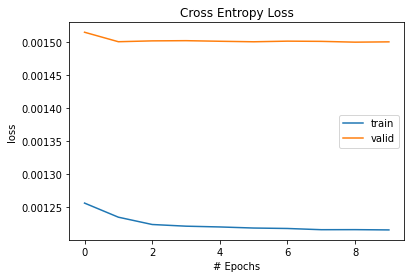

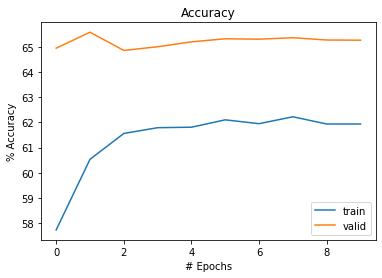

In [82]:
all_preds = []
all_preds2 = []
def evaluate_rnn(transformer_model, t_valid_x, t_valid_y, loss_mask_valid):
    transformer_model.eval()
    with torch.no_grad():
      acc = 0
      count = 0
      acc_total = 0
      loss_total = 0
      num_batches = t_valid_x.shape[0]
      for batch in range(29):
          src = t_valid_x[batch,:,:,:].to(device).float()
          tgt = t_valid_y[batch] + 0
          loss_mask_batch = loss_mask_valid[batch, :, :]
          out, _ = transformer_model(src)
          out = torch.sigmoid(out[:,:, [0]]).squeeze(-1)
          prediction = out>0.5
          all_preds.append(prediction)
          acc = torch.sum((tgt== prediction) *(loss_mask_batch))
          loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
          loss_total += loss
          acc_total += acc
          count+= torch.sum(loss_mask_batch)
      print("evaluation acc: {}, loss: {}".format(acc_total/count, loss_total / count))
    return acc_total/count, loss_total / count

num_batches = t_train_x.shape[0]
lstm_model = torch.nn.LSTM(10, 10, 2)
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model.train()
num_batches = t_train_x.shape[0]
num_epochs = 10
log_interval = 10
total_loss = 0
plot_loss= []
plot_acc= []
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    for batch in tqdm(range(50)):
      optim.zero_grad()
      src = t_train_x[batch,:,:,:].to(device).float()
      tgt = t_train_y[batch] + 0
      loss_mask_batch = loss_mask_train[batch, :, :]
      out, _ = lstm_model(src)
      out = torch.sigmoid(out[:, :, 0]).squeeze(-1)
      prediction = out>0.5
      all_preds_count = 0
      true_pred = 0
      # print(prediction.shape) # calculates the average number of predicted correct answers.
      # for row in prediction:
      #   for p in row:
      #     if p == True:
      #       true_pred+=1
      #     all_preds_count+=1
      # print(f"avg is {true_pred/all_preds_count}")
      # print()
      acc = torch.sum((tgt== prediction) *(loss_mask_batch)) /torch.sum(loss_mask_batch)
      plot_acc.append(acc)
      loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
      loss.backward()
      optim.step()
      if (batch+1)%log_interval == 0:
        plot_loss.append(total_loss)
        total_loss = 0
      total_loss += loss.item()
    print("train")
    train_acc, train_loss = evaluate_rnn(lstm_model, t_train_x,  t_train_y, loss_mask_train)
    print("valid")
    valid_acc, valid_loss = evaluate_rnn(lstm_model, t_valid_x,  t_valid_y, loss_mask_valid)
    train_losses.append(train_loss.item())
    train_accs.append(train_acc*100)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc*100)
plt.plot(train_losses, label = "train")
plt.plot(valid_losses, label = "valid")
plt.title('Cross Entropy Loss')
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(train_accs,  label = "train")
plt.plot(valid_accs,  label = "valid")
plt.title('Accuracy')
plt.xlabel('# Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()


In [78]:
total_all_sum = 0
for i in all_preds:
    total_all_sum += i
print(total_all_sum.shape)
print(total_all_sum / len(all_preds))

print(all_preds2)
total_all_sum2 = 0
for i in all_preds2:
    for x in i:
        total_all_sum2 += x
print(total_all_sum2.shape)
print(total_all_sum2 / len(all_preds2))

torch.Size([16, 256])
tensor([[0.7414, 0.8466, 0.7810,  ..., 0.6000, 0.6000, 0.6000],
        [0.7017, 0.8276, 0.7483,  ..., 1.0000, 1.0000, 1.0000],
        [0.8121, 0.8517, 0.8207,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.7586, 0.5845, 0.5466,  ..., 0.9983, 1.0000, 0.9983],
        [0.7552, 0.6724, 0.5845,  ..., 0.9966, 0.9983, 0.9966],
        [0.7155, 0.6397, 0.5914,  ..., 0.9966, 0.9983, 0.9983]])
[<generator object <genexpr> at 0x131e31190>, <generator object <genexpr> at 0x131e31580>, <generator object <genexpr> at 0x131e312e0>, <generator object <genexpr> at 0x131e319e0>, <generator object <genexpr> at 0x131e31900>, <generator object <genexpr> at 0x131e31120>, <generator object <genexpr> at 0x131e31040>, <generator object <genexpr> at 0x1316c3f20>, <generator object <genexpr> at 0x1316c3e40>, <generator object <genexpr> at 0x1316c3d60>, <generator object <genexpr> at 0x1316c3c80>, <generator object <genexpr> at 0x1316c3f90>, <generator object <genexpr> at 0x1316c3

# Train transfomer

cpu


100%|██████████| 138/138 [00:10<00:00, 12.65it/s]


evaluation acc of train: 0.48025668230451624, loss: 0.001261374683672038
evaluation acc of valid: 0.4980459738920401, loss: 0.0016914201725473858


100%|██████████| 138/138 [00:09<00:00, 14.30it/s]


evaluation acc of train: 0.5392118012501758, loss: 0.0012255708503132456
evaluation acc of valid: 0.5873476809509593, loss: 0.0016181236599076474


100%|██████████| 138/138 [00:10<00:00, 12.97it/s]


evaluation acc of train: 0.5600352810338877, loss: 0.0012131026933112515
evaluation acc of valid: 0.6113252096507178, loss: 0.001598986427384792


100%|██████████| 138/138 [00:09<00:00, 13.96it/s]


evaluation acc of train: 0.5695202546370272, loss: 0.0012044249242708902
evaluation acc of valid: 0.6127364507286889, loss: 0.0015954488210117395


100%|██████████| 138/138 [00:10<00:00, 13.78it/s]


evaluation acc of train: 0.577215610579197, loss: 0.001199803488076945
evaluation acc of valid: 0.619466985100551, loss: 0.0015905301148983592


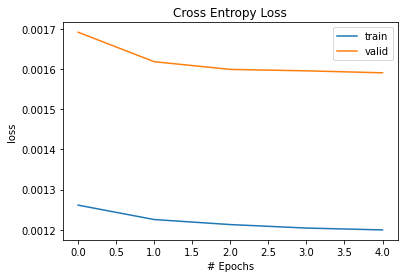

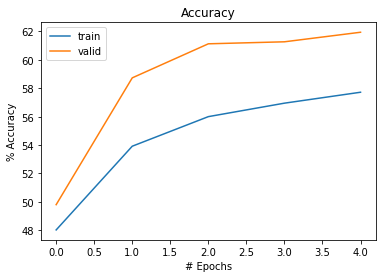

In [84]:
def evaluate(transformer_model,t_valid_x, t_valid_y , loss_mask_valid, name_data = ""):
    transformer_model.eval()
    with torch.no_grad():
      acc = 0
      count = 0
      acc_total = 0
      loss_total = 0
      num_batches = t_valid_x.shape[0]
      for batch in range(num_batches):

          src = t_valid_x[batch,:,:,:].to(device).float()
          tgt = t_valid_y[batch] + 0
          loss_mask_batch = loss_mask_valid[batch, :, :]
          out = transformer_model(src)
          out = torch.sigmoid(out).squeeze(-1)
          prediction = out>0.5
          acc = torch.sum((tgt== prediction) *(loss_mask_batch))
          loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
          loss_total += loss
          acc_total += acc
          count+= torch.sum(loss_mask_batch)
      print("evaluation acc of {}: {}, loss: {}".format(name_data, acc_total/count, loss_total / count))
    return acc_total/count, loss_total / count


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_batches = t_train_x.shape[0]
transformer_model = TransformerModel(d_model = 10, n_heads=2, n_encoder_layers=3, dropout = 0.1)
optim = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
transformer_model.train()
num_batches = t_train_x.shape[0]
num_epochs = 5
log_interval = 10
total_loss = 0
plot_loss= []
plot_acc= []
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):
    for batch in tqdm(range(num_batches)):
      optim.zero_grad()
      src = t_train_x[batch,:,:,:].to(device).float()
      tgt = t_train_y[batch] + 0
      loss_mask_batch = loss_mask_train[batch, :, :]
      out = transformer_model(src)
      out = torch.sigmoid(out).squeeze(-1)
      prediction = out>0.5
      acc = torch.sum((tgt== prediction) *(loss_mask_batch)) /torch.sum(loss_mask_batch)
#       print("acc", acc)
      plot_acc.append(acc)
      loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
      loss.backward()
      optim.step()
#       if (batch+1)%log_interval == 0:
#         plot_loss.append(total_loss)
#         total_loss = 0
#       total_loss += loss.item()
    # evaluate returns acc, loss. 
    train_acc, train_loss = evaluate(transformer_model, t_train_x,  t_train_y, loss_mask_train, "train")
    valid_acc, valid_loss = evaluate(transformer_model, t_valid_x,  t_valid_y, loss_mask_valid,  "valid")
    train_losses.append(train_loss.item())
    train_accs.append(train_acc*100) 
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc*100)
plt.plot(train_losses, label = "train")
plt.plot(valid_losses, label = "valid")
plt.title('Cross Entropy Loss')
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(train_accs,  label = "train")
plt.plot(valid_accs,  label = "valid")
plt.title('Accuracy')
plt.xlabel('# Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()


In [85]:
print(len(t_train_x))

138
